# About this notebook

In this notebook, we apply CIDRE to a network with communities and demonstrate how to use CIDRE and visualize the detected groups.

## Install CIDRE package

In [30]:
!pip install cidre


## Loading libraries

In [67]:
import sys
import numpy as np
from scipy import sparse
import pandas as pd
import cidre
import networkx as nx

# Example 1

Next, we load a network. We first present an example of a small artificial network.

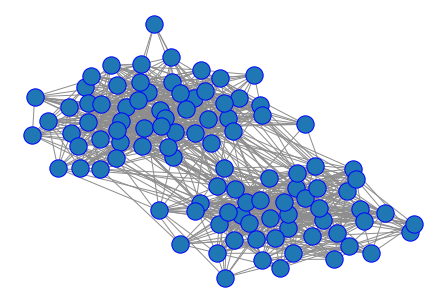

In [84]:
# Data path
edge_file = "https://raw.githubusercontent.com/skojaku/cidre/main/data/synthe/edge-table.csv"
node_file = "https://raw.githubusercontent.com/skojaku/cidre/main/data/synthe/node-table.csv"

# Load
node_table = pd.read_csv(node_file)
A, node_labels = cidre.utils.read_edge_list(edge_file)

# Visualization
nx.draw(nx.from_scipy_sparse_matrix(A), linewidths = 1, edge_color="#8d8d8d", edgecolors="b")

We constructed this synthetic network by generating a network using a stochastic block model (SBM) composed of two blocks and then adding excessive citation edges among uniformly randomly selected pairs of nodes. Each block corresponds to a community, i.e., a group of nodes that are densely connected with each other within it but sparsely connected with those in the opposite group. Such communities overshadow anomalous groups in networks. 

Let's pretend that we do not know that the network is composed of two communities plus additional edges. To run CIDRE, we first need to find the communities. To use `graph-tool` package to do this, install `graph-tool` by 

```python
conda install -c conda-forge graph-tool
```

or in the Colaboratory:

In [29]:
%%capture
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-cairo python3-matplotlib

Now, let's detect communities by fitting the degree-corrected stochastic block model (dcSBM) to the network and consider each detected block as a community.

Our approach hinges on the assumption that the anomalous groups are not detected by the community detection algorithm. If we allow the number of communities to be large in this example, we would find anonalous groups as communities. Therefore, we limit the number of communities to be at most 3 to prevent the SBM to detect small anomalous groups. This workaround is artificial. However, we do not need to impose it in the case of large networks (see Example 2 below) because small anomalous groups usually have little impact on the global community structure, and thus the SBM would not find them as communities.

In [85]:
import graph_tool.all as gt

def detect_community(A, K = None, **params):
    """Detect communities using the graph-tool package

    :param A: adjacency matrix
    :type A: scipy.csr_sparse_matrix
    :param K: Maximum number of communities. If K = None, the number of communities is automatically determined by graph-tool.
    :type K: int or None
    :param params: parameters passed to graph_tool.gt.minimize_blockmodel_dl
    """
    def to_graph_tool_format(adj, membership=None):
        g = gt.Graph(directed=True)
        r, c, v = sparse.find(adj)
        nedges = v.size
        edge_weights = g.new_edge_property("double")
        g.edge_properties["weight"] = edge_weights
        g.add_edge_list(
            np.hstack([np.transpose((r, c)), np.reshape(v, (nedges, 1))]),
            eprops=[edge_weights],
        )
        return g
    G = to_graph_tool_format(A)

    states = gt.minimize_blockmodel_dl(
        G,
        state_args=dict(eweight=G.ep.weight),
        multilevel_mcmc_args = {"B_max": A.shape[0] if K is None else K },
        **params
    )
    b = states.get_blocks()
    return np.unique(np.array(b.a), return_inverse = True)[1]

In [87]:
group_membership = detect_community(A)

Now, we feed the network and its community structure to CIDRE. To to this, we create a `cidre.Cidre` object and input `group_membership` along with some key parameters to `cidre.Cidre`.

In [88]:
alg = cidre.Cidre(group_membership = group_membership, alpha = 0.5, min_edge_weight = 1)

- `alpha` (default 0.01) is the statistical significance level.
- `min_edge_weight` is the threshold of the edge weight, i.e., the edges with weight less than this value will be removed.

Then, we input the network to `cidre.Cidre.detect`.

In [89]:
groups = alg.detect(A, threshold=0.05)

`groups` is a list of `Group` instances. We can get the donor nodes of a group, for example `groups[0]`, by

In [90]:
groups[0].donors

{66: 0.3888888888888889, 70: 0.65}

The keys and values of this dict object are the IDs of the nodes and their donor scores, respectively. The recipients and their recipient scores can be obtained by

In [91]:
groups[0].recipients

{1: 0.5384615384615384, 49: 0.6333333333333333, 62: 0.3888888888888889}

`cidre` package provides an API to visualize small groups. To use this API, we first need to import some additional libraries.

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

Then, plot the group by

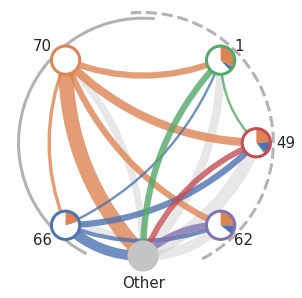

In [94]:
# The following three lines are purely for visual enhancement, i.e., changing the saturation of the colors and font size.
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")

# Set the figure size
width, height = 5,5
fig, ax = plt.subplots(figsize=(width, height))

# Plot a citation group
cidre.DrawGroup().draw(groups[0], ax = ax)


# Example 2

Let's go through another example, which is a much large empirical citation network, i.e., the citation network of journals in 2013.

In [95]:
# Data path
edge_file = "https://raw.githubusercontent.com/skojaku/cidre/main/data/journal-citation/edge-table-2013.csv"
node_file = "https://raw.githubusercontent.com/skojaku/cidre/main/data/journal-citation/community-label.csv"

# Load
node_table = pd.read_csv(node_file)
A, node_labels = cidre.utils.read_edge_list(edge_file)

## About this network

This network is a citation network of journals in 2013 constructed from Microsoft Academic Graph.
Each edge is weighted by the number of citations made to papers in the prior two years.
The following are the basic statistics of this network.

In [ ]:
print("Number of nodes: %d" % A.shape[0])
print("Number of edges: %d" % A.sum())
print("Average degree: %.2f" % (A.sum()/A.shape[0]))
print("Max in-degree: %d" % np.max(A.sum(axis = 0)))
print("Max out-degree: %d" % np.max(A.sum(axis = 1)))
print("Maximum edge weight: %d" % A.max())
print("Minimum edge weight: %d" % np.min(A.data))

## Communities overshadow anomalous groups

Now, let us demonstrate how community structure makes it difficult to find anomalous groups. To this end, we run CIDRE without telling it about the communities in the network.

In [ ]:
# Group detection
# alpha: statistical significance level to find anomalous edges.
# min_edge_weight: the edges with weight less than this value will be removed prior to detecting groups.
alg = cidre.Cidre(group_membership = None, alpha = 0.01, min_edge_weight = 10)
groups = alg.detect(A, threshold=0.15)

Let see the number of nodes in the group, which can be obtained by `.size` API of `Group` class:

In [ ]:
# group.size() will return the number of nodes in the group
print("The number of journals in the largest group: %d" % np.max([group.size() for group in groups]))
print("Number of groups detected: %d" % len(groups))

CIDRE detected a super large group composed of more than 6000 journals, which would not be anomalous.

What happens?

This group consists of journals of related fields. Because they are frequently citing with each other, CIDRE detects them as an anomalous group. This problem---looking for anomalous group of densely connected nodes results in finding non-suspecious communities---can occur not only with CIDRE but also with other methods based on community detection. It is, therefore, crucial to discount the effect of such dominant "normal" communities to find "anomalous" groups.

## Finding anomalous groups in the network

It is straightforward to tell CIDRE the "normal" communities in the network. Deciding what should be "normal" is your modelling decision. In context of the journal citation network, we consider journals in the same field as a normal citation community, and use a community detection algorithm (the degree-corrected stochastic block model) to identify the "normal" communities.

To tell the normal communities to CIDRE, pass an array indicating group membership of nodes, `group_membership`, where `group_membership[i]` indicates the ID of the group to which node i belongs.

We use the group membership in `node_table`. `node_table` consists of `journal_id`  and `community_id` columns, from which we prepare `group_membership` array as follows.

In [ ]:
# Get group membership
node2com = dict(zip(node_table["journal_id"], node_table["community_id"]))
group_membership = [node2com[node_labels[i]] for i in range(A.shape[0])]

And then pass `group_membership` to `Cidre` class.

In [ ]:
alg = cidre.Cidre(group_membership = group_membership, alpha = 0.01, min_edge_weight = 10)
groups = alg.detect(A, threshold=0.15)

In [ ]:
print("The number of journals in the largest group: %d" % np.max([group.size() for group in groups]))
print("Number of groups detected: %d" % len(groups))

CIDRE detected a much smaller group composed of 16 journals.

## Visualizing anomalous groups

Let us visualize the groups detected by CIDRE. As a demonstration, we random sample three groups.

In [ ]:
# group.get_num_edges() gives the total weight of edges within the group
groups_filtered = [group for group in groups if group.get_num_edges()>50] # Filter out the groups with total within-group edge weight less than 50
groups_sampled = [groups_filtered[i] for i in np.random.choice(len(groups_filtered), 3, replace = False)]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")

fig, axes = plt.subplots(ncols = 3, figsize=(6 * 3, 5))

for i in range(3):
    cidre.DrawGroup().draw(groups_sampled[i], ax = axes.flat[i])

Let's place journal name instead of node IDs. To this end, we load node lables and make a dictionary from ID to label:

In [ ]:
df = pd.read_csv("../data/journal-citation/journal_names.csv")
journalid2label = dict(zip(df.journal_id.values, df.name.values)) # MAG journal id -> Journal Name

id2label = {k:journalid2label[v] for k, v in node_labels.items()} # Dictionary from IDs to labels

In [ ]:
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")

fig, axes = plt.subplots(ncols = 3, figsize=(8 * 3, 5))

for i in range(3):
    plotter = cidre.DrawGroup()
    plotter.font_size = 12 # Font size
    plotter.label_node_margin = 0.5 # Margin between labels and node
    plotter.draw(groups_sampled[i], node_labels = id2label, ax = axes.flat[i])